In [1]:
# Some initializations
import numpy as np
import torch
import torchvision
from skimage import color
import random
import matplotlib.pyplot as plt
import sys
import os
import pprint
sys.path.append(os.path.abspath('../src/'))

import lib.utils as utils
from lib.data.worms_dataset import WormsDataset
from scripts.settings import Settings, DEFAULT_PATH

%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
sett = Settings('train_default.toml')
if not sett.PATH.EXPERIMENT_ROOT:
    sett.PATH.EXPERIMENT_ROOT = DEFAULT_PATH.EXPERIMENTS
if not sett.PATH.WORMS_DATASET:
    sett.PATH.WORMS_DATASET = DEFAULT_PATH.WORMS_DATASET
if not sett.PATH.CPM_DATASET:
    sett.PATH.CPM_DATASET = DEFAULT_PATH.CPM_DATASET

print(sett)


[NAME]: default
[PATH]: 	
	[EXPERIMENT_ROOT]: /home/ashkan/workspace/deployed/worms_nuclei_metric_learning-deployed/experiments
	[WORMS_DATASET]: /home/ashkan/workspace/deployed/worms_nuclei_metric_learning-deployed/data/processed/worms_dataset
	[CPM_DATASET]: /home/ashkan/workspace/deployed/worms_nuclei_metric_learning-deployed/data/processed/cpm_dataset.pkl
[GENERAL]: 	
	[LOGGING]: 10
	[OVERWRITE]: False
	[DEBUG]: False
	[SEED]: 1234
[MODEL]: 	
	[MODEL_NAME]: unet
	[MODEL_PARAMS]: [1, 64, 5, 6]
	[INIT_MODEL_PATH]: None
	[INIT_MODEL_BEST]: False
	[INIT_MODEL_LAST]: False
[TRAIN]: 	
	[N_CLUSTER]: 558
	[N_STEP]: 100000
	[MODEL_CKPT_EVERY_N_STEP]: 20000
	[RUNNING_LOSS_INTERVAL]: 1000
	[BURN_IN_STEP]: 50000
	[LEARNING_RATE]: 0.001
	[WEIGHT_DECAY]: 0
	[LR_DROP_FACTOR]: 0.1
	[LR_DROP_PATIENCE]: 20
	[AUGMENTATION]: 		
		[ELASTIC]: 			
			[CONTROL_POINT_SPACING]: [10, 10, 10]
			[JITTER_SIGMA]: [1, 1, 1]
			[ROTATION_INTERVAL]: [-5, 5]
			[SUBSAMPLE]: 1
			[P]: 0.8
[DATA]: 	
	[N_WORKER]: 10


In [3]:
# helper function for visualization
def plot_train_data(sample, num_slice=5):
    raw = sample['raw'].numpy()
    label = sample['label'].numpy()
    orig_raw = sample['original_raw'].numpy()
    orig_label = sample['original_label'].numpy()
    
    n_instance = sample['n_cluster'].numpy()  # use this to generate color list, to get consistent colors between images
#     cmap = plt.get_cmap('tab20c')
#     colors = [cmap(1.*i/n_instance) for i in range(n_instance)]
    
    # plot only num_slices of z
    slices = random.choices(range(raw.shape[-1]), k=num_slice)
    
    # batch size tells us n_instances returned by dataset
    n_col = raw.shape[0]
    
    fig = plt.figure(figsize=(15,15))
    fig.suptitle(f"corner=[{sample['corner']}] - n_instance=[{sample['n_cluster']}]")
    for no, sl in enumerate(slices):
        for j in range(n_col):
            fig.add_subplot(num_slice, 3*n_col, no*3*n_col+3*j+1)
            plt.imshow(np.squeeze(raw[j,0,:,:,sl]), cmap='gray')
            
            fig.add_subplot(num_slice, 3*n_col, no*3*n_col+3*j+2)
            plt.imshow(orig_raw[j,:,:,sl], cmap='gray')
            plt.imshow(color.label2rgb(orig_label[j,:,:,sl], bg_label=0), alpha=0.2)
            plt.title(str(np.unique(orig_label[j,:,:,sl])))
        
            fig.add_subplot(num_slice, 3*n_col, no*3*n_col+3*j+3)
            # we need to get argmax, bcuz labels are expanded into n_instance dimensions
            ll = label[j]
            ll = np.argmax(ll, axis=0)
            l = ll[:, :, sl]
            plt.title(str(np.unique(l)))
            plt.imshow(color.label2rgb(l, bg_label=0))

### n_consistent_worms = 1
This is for sanity check

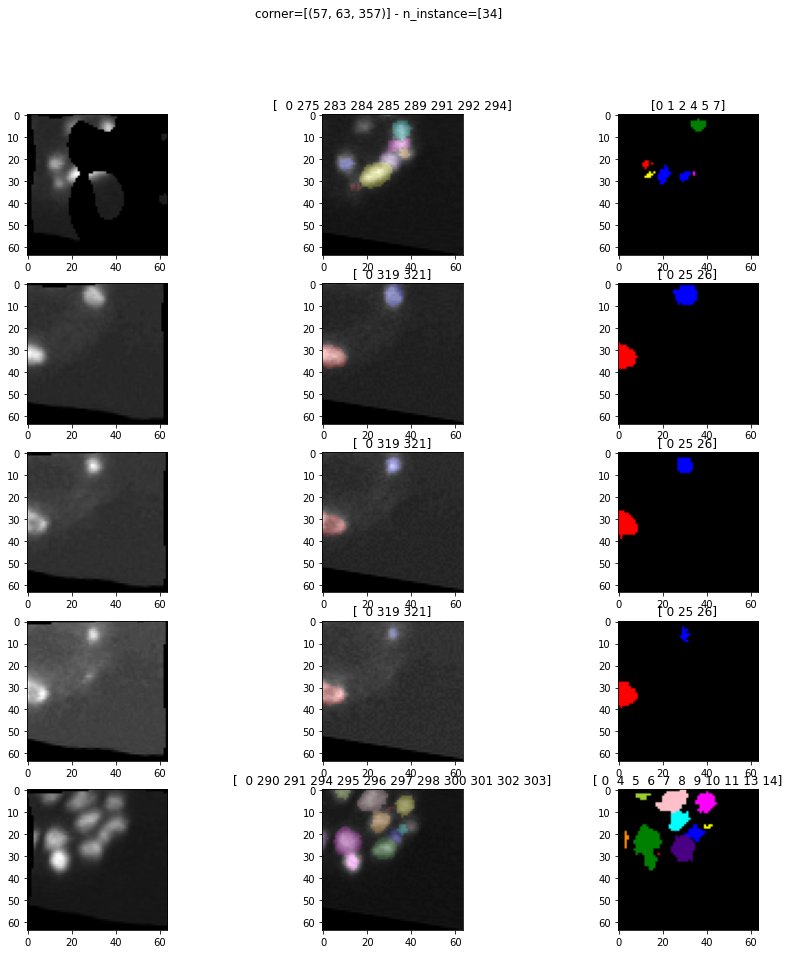

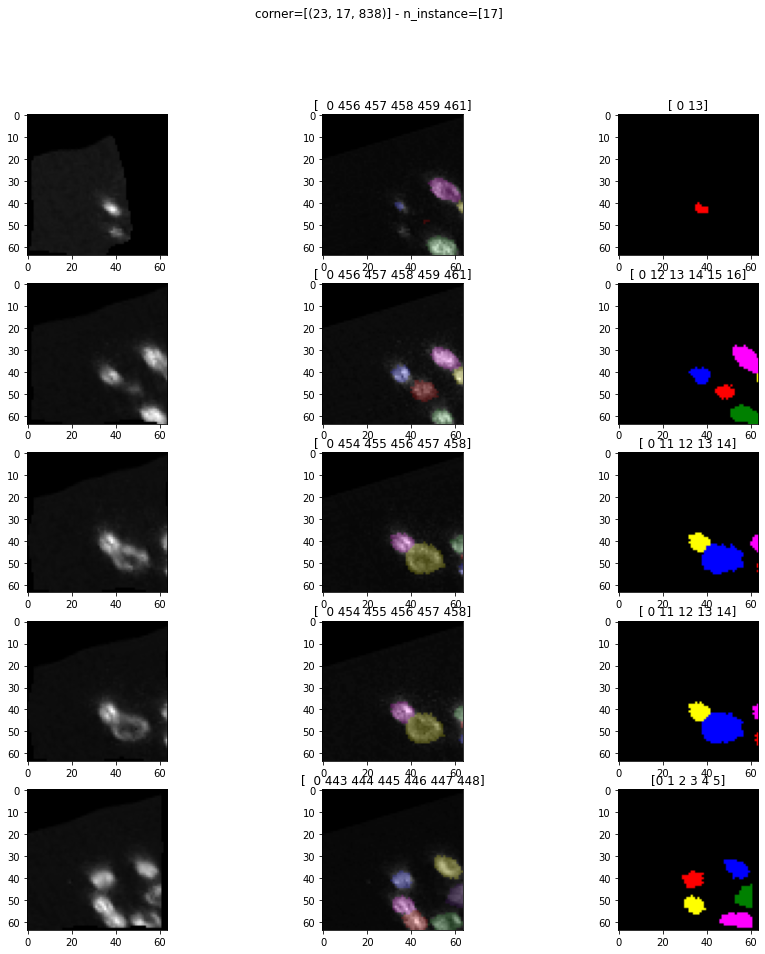

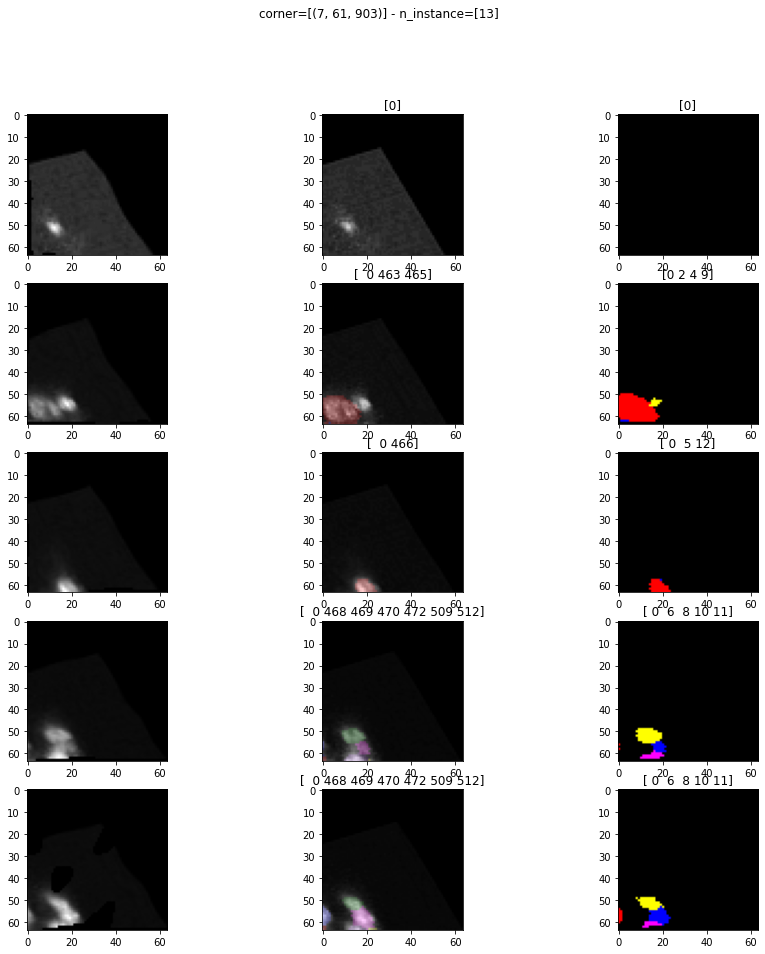

In [4]:
sett.DATA.PATCH_SIZE = [64, 64, 64]
sett.DATA.N_CONSISTENT_WORMS = 1

train_dataset = WormsDataset(
    sett.PATH.WORMS_DATASET,
    sett.PATH.CPM_DATASET,
    patch_size=sett.DATA.PATCH_SIZE,
    n_consistent_worms=sett.DATA.N_CONSISTENT_WORMS,
    use_leftout_labels=sett.DATA.USE_LEFTOUT_LABELS,
    use_coord=sett.DATA.USE_COORD,
    normalize=sett.DATA.NORMALIZE,
    augmentation=sett.TRAIN.AUGMENTATION,
    debug=True)

train_loader = iter(train_dataset)
for _ in range(3):
    sample = next(train_loader)
    plot_train_data(sample)

# n_consistent_worms = 2

### default setup

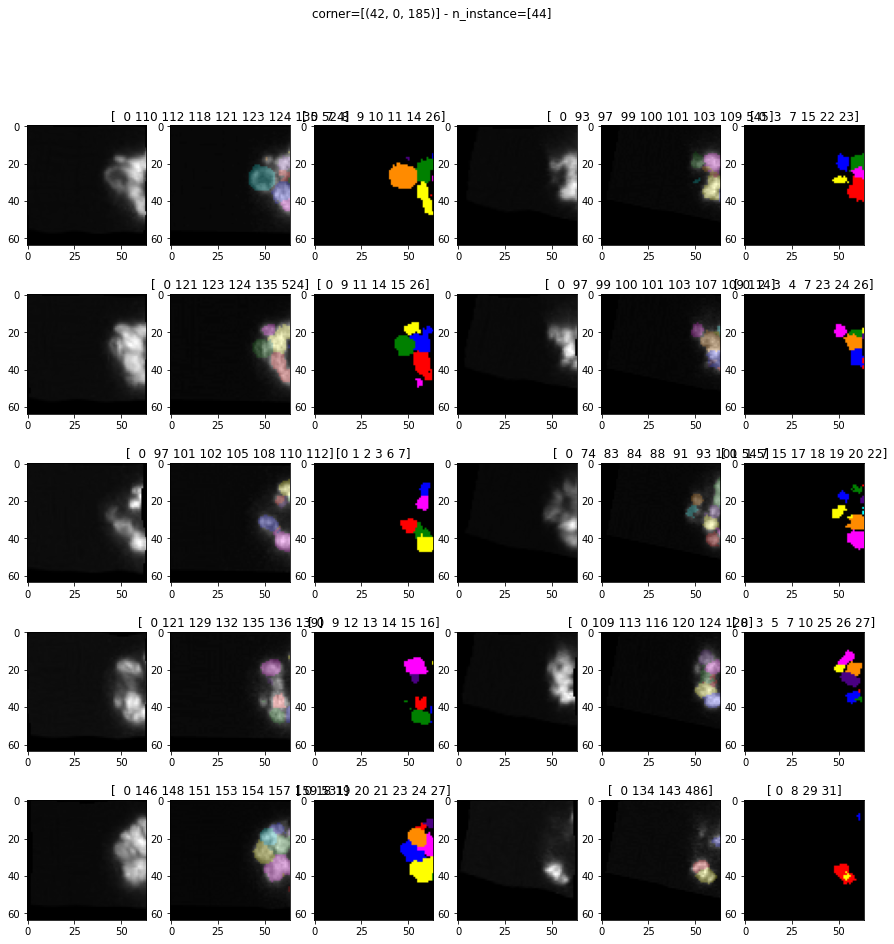

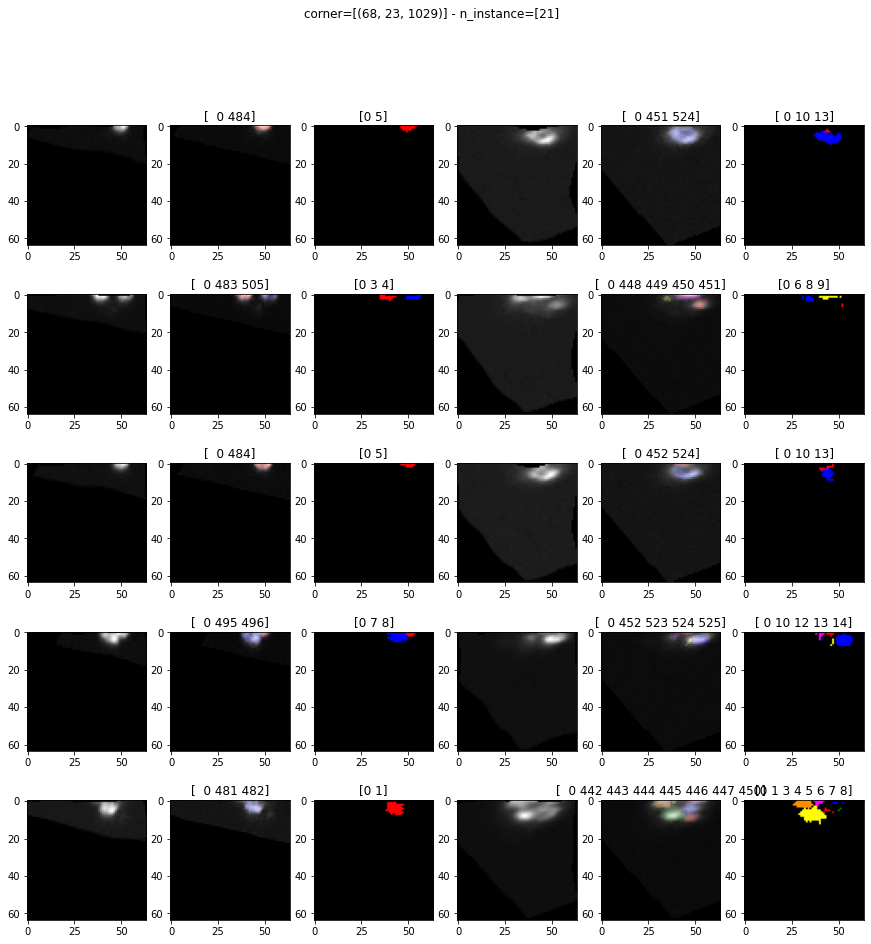

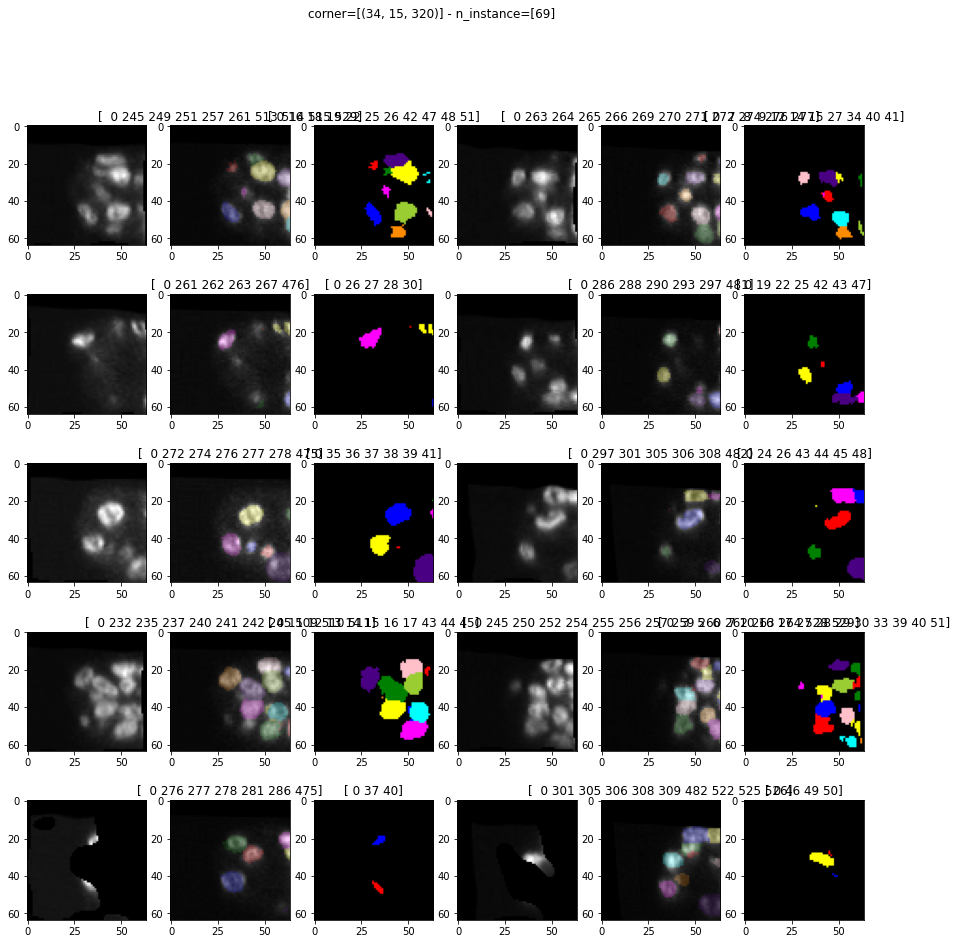

In [5]:
sett.DATA.N_CONSISTENT_WORMS = 2

train_dataset = WormsDataset(
    sett.PATH.WORMS_DATASET,
    sett.PATH.CPM_DATASET,
    patch_size=sett.DATA.PATCH_SIZE,
    n_consistent_worms=sett.DATA.N_CONSISTENT_WORMS,
    use_leftout_labels=sett.DATA.USE_LEFTOUT_LABELS,
    use_coord=sett.DATA.USE_COORD,
    normalize=sett.DATA.NORMALIZE,
    augmentation=sett.TRAIN.AUGMENTATION,
    debug=True)

train_loader = iter(train_dataset)
for _ in range(3):
    sample = next(train_loader)
    plot_train_data(sample)

### without elastic augmentation

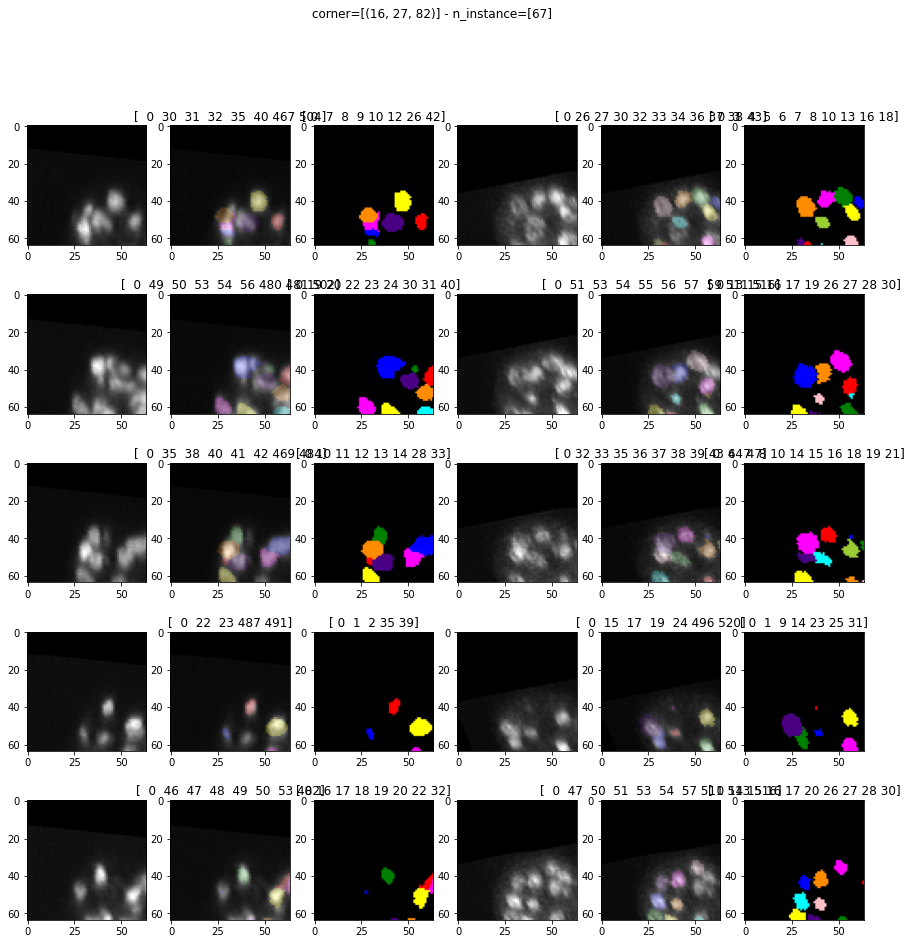

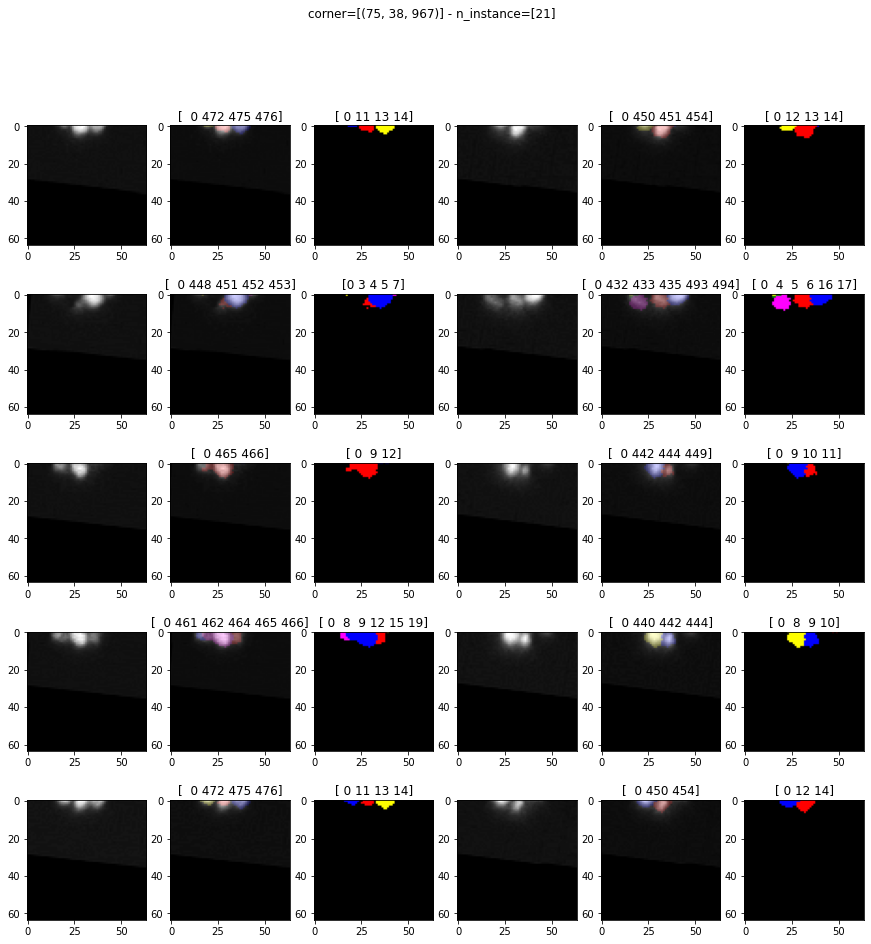

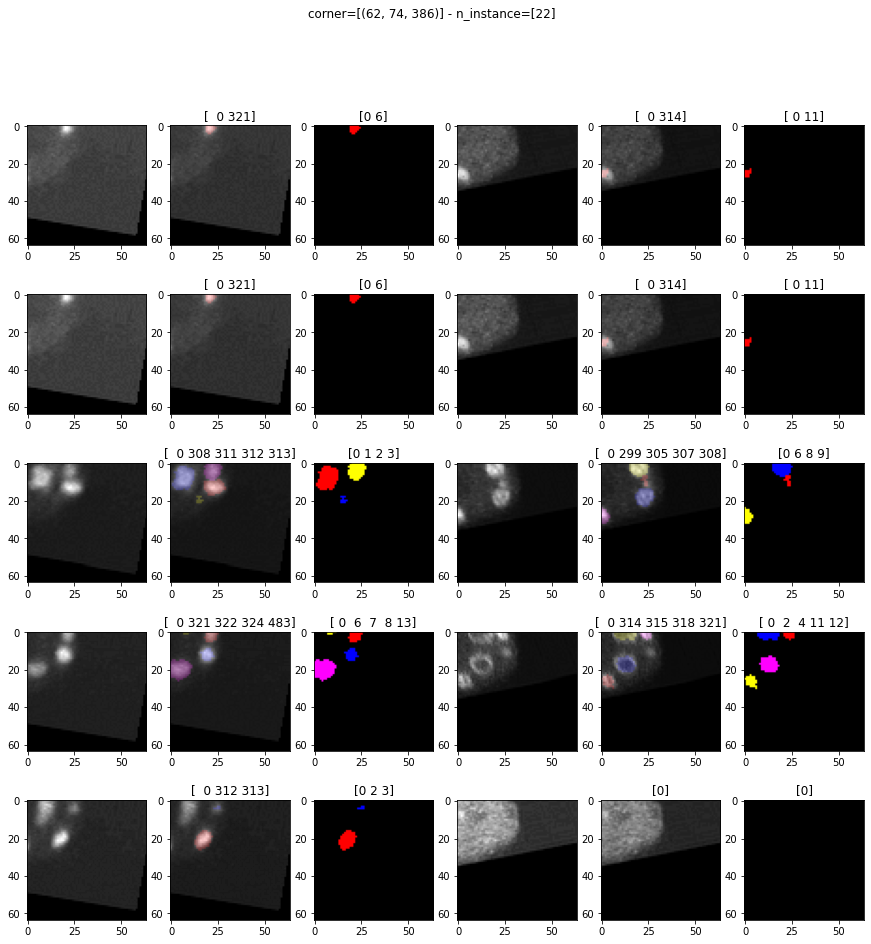

In [6]:
train_dataset = WormsDataset(
    sett.PATH.WORMS_DATASET,
    sett.PATH.CPM_DATASET,
    patch_size=sett.DATA.PATCH_SIZE,
    n_consistent_worms=sett.DATA.N_CONSISTENT_WORMS,
    use_leftout_labels=sett.DATA.USE_LEFTOUT_LABELS,
    use_coord=sett.DATA.USE_COORD,
    normalize=sett.DATA.NORMALIZE,
    augmentation=None,
    debug=True)

train_loader = iter(train_dataset)
for _ in range(3):
    sample = next(train_loader)
    plot_train_data(sample)

### do not use_leftout_labels

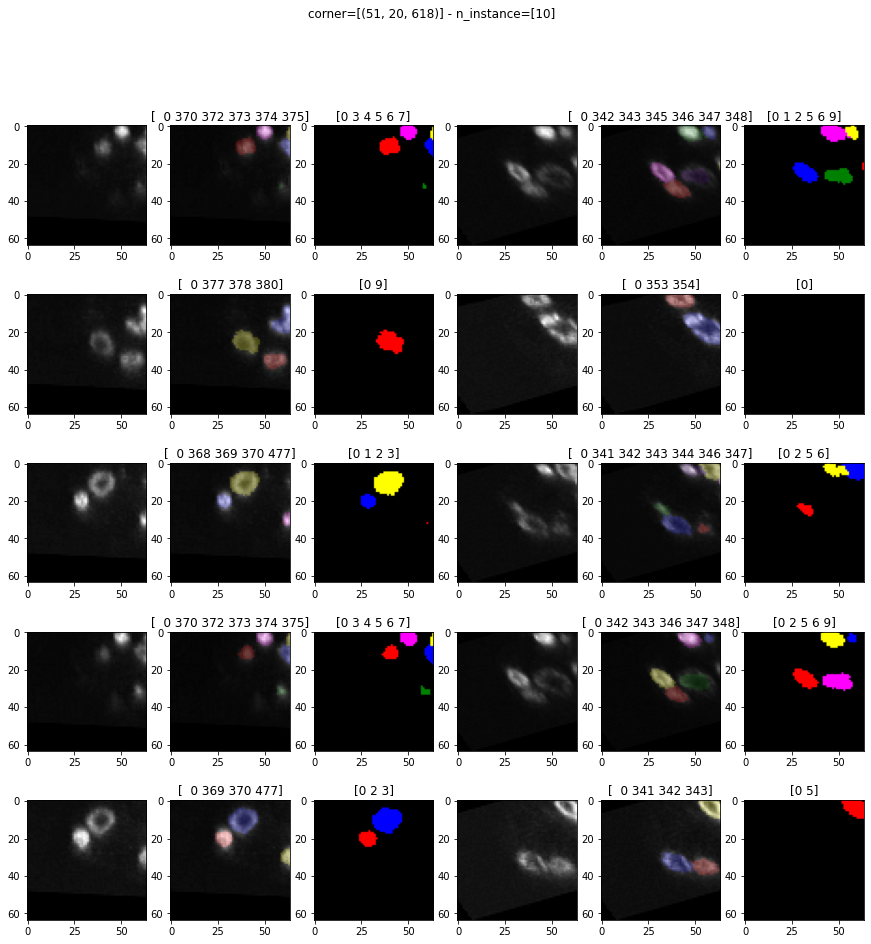

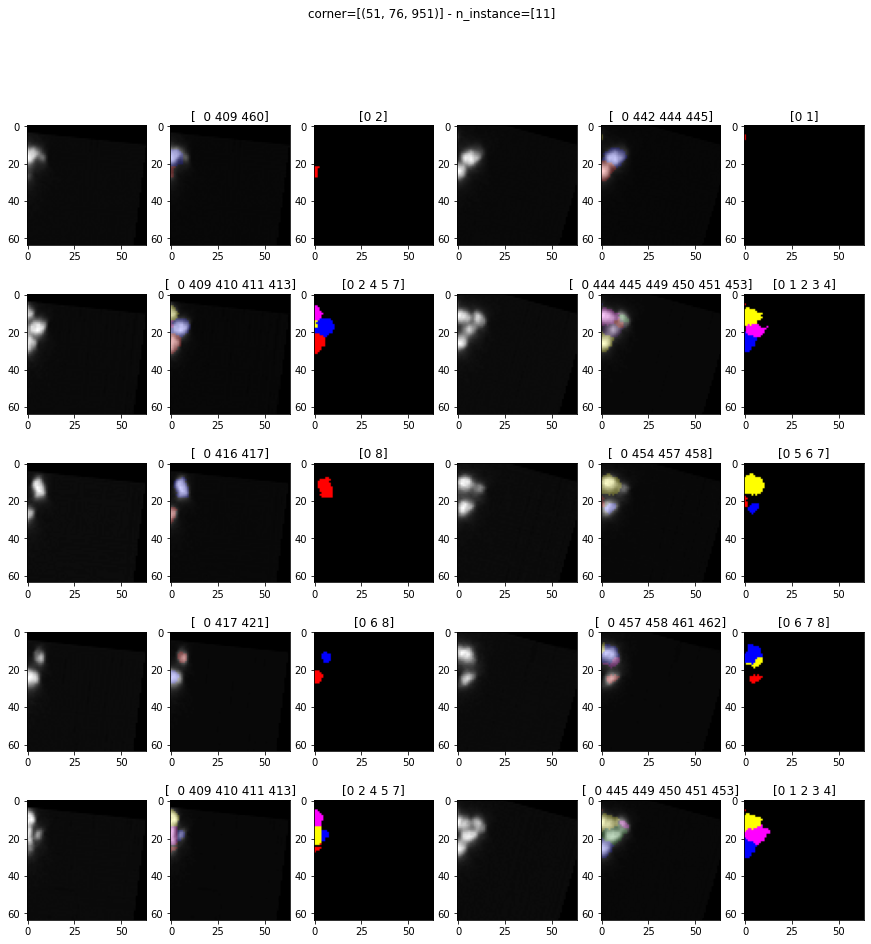

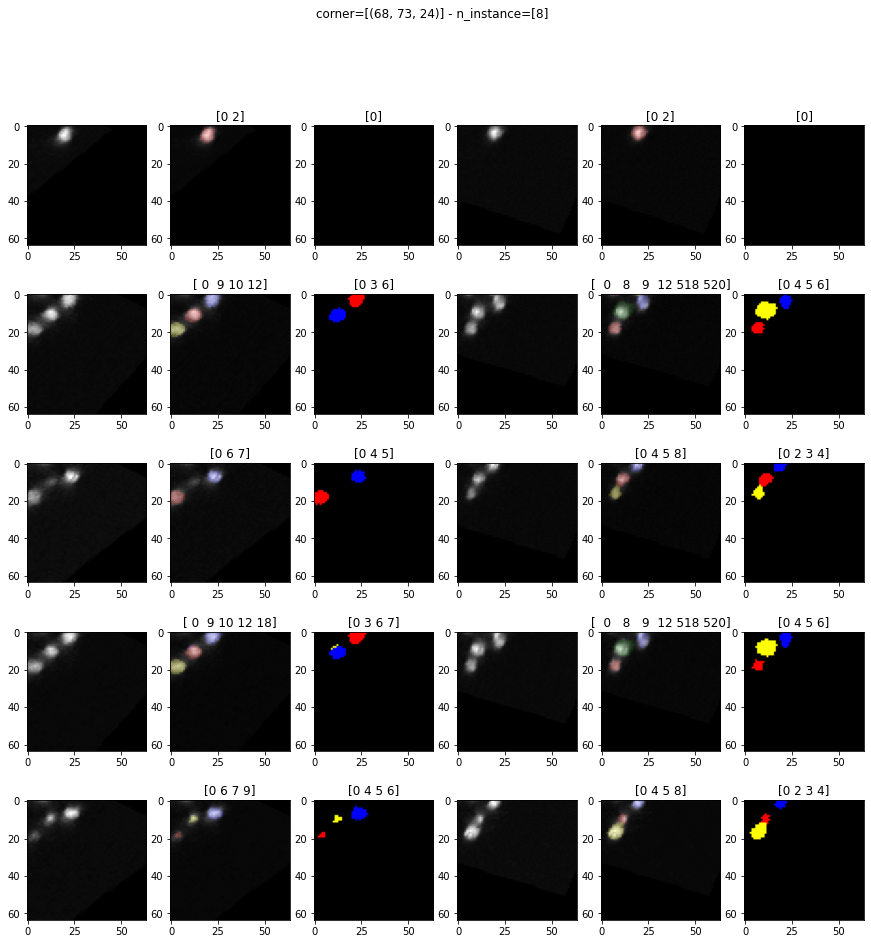

In [7]:
train_dataset = WormsDataset(
    sett.PATH.WORMS_DATASET,
    sett.PATH.CPM_DATASET,
    patch_size=sett.DATA.PATCH_SIZE,
    n_consistent_worms=sett.DATA.N_CONSISTENT_WORMS,
    use_leftout_labels=False,
    use_coord=sett.DATA.USE_COORD,
    normalize=sett.DATA.NORMALIZE,
    augmentation=None,
    debug=True)

train_loader = iter(train_dataset)
for _ in range(3):
    sample = next(train_loader)
    plot_train_data(sample)

### smaller patch sizes

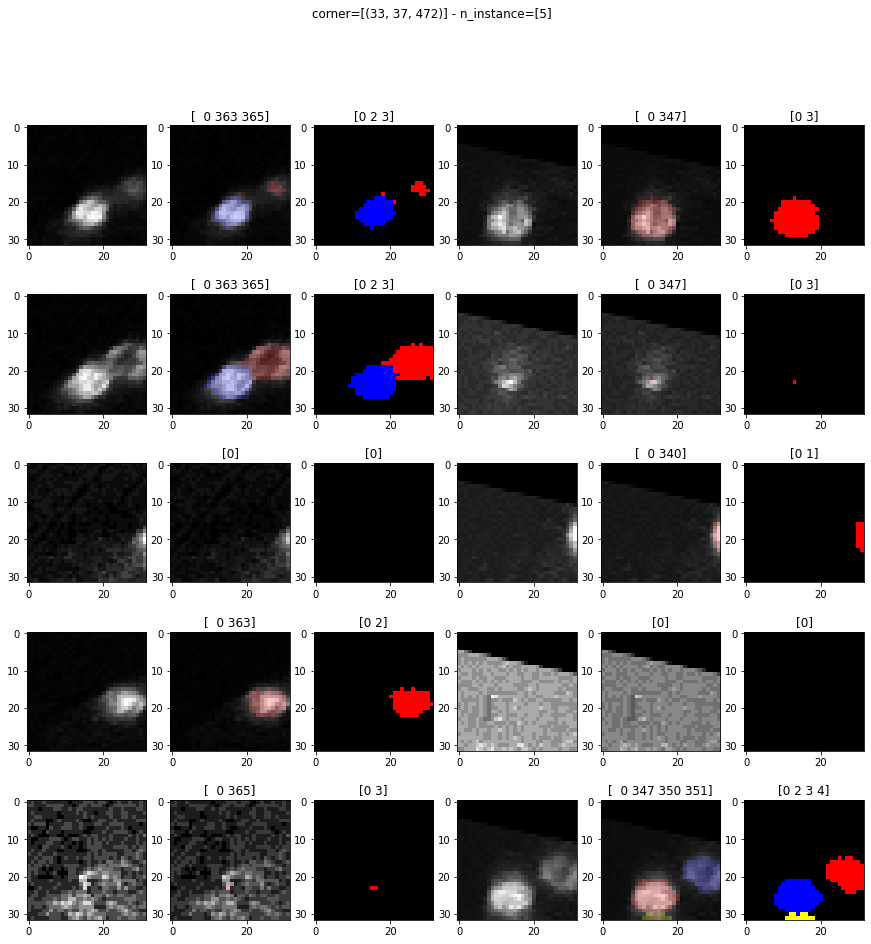

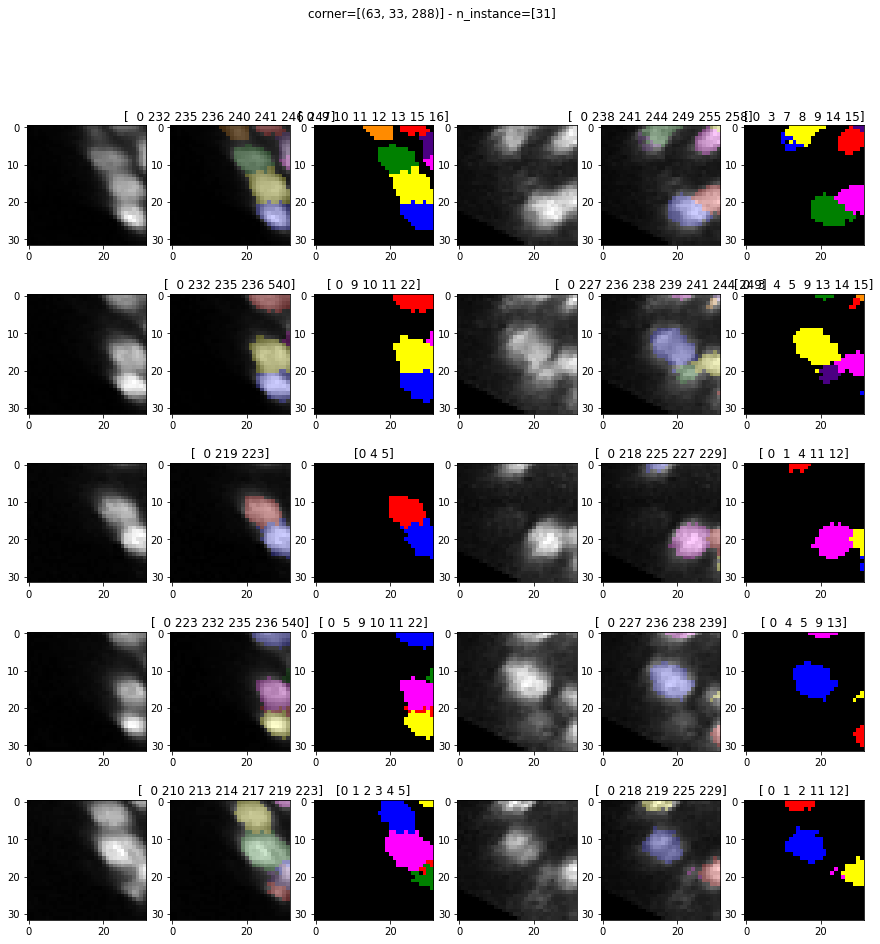

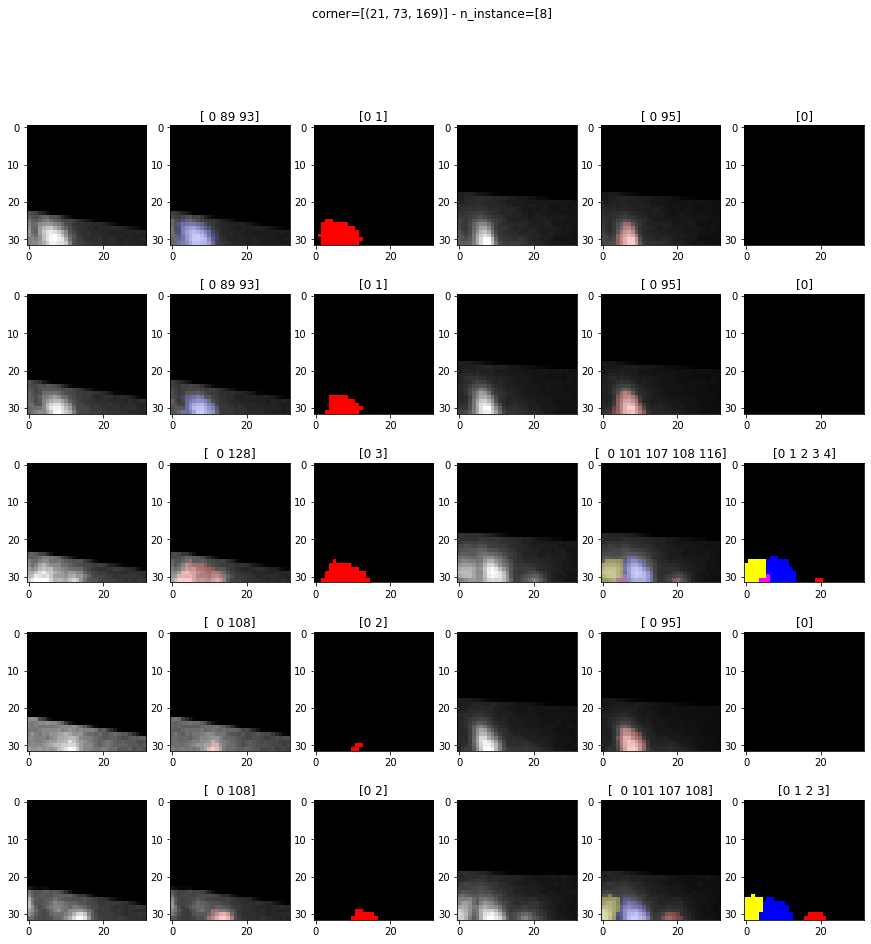

In [8]:
train_dataset = WormsDataset(
    sett.PATH.WORMS_DATASET,
    sett.PATH.CPM_DATASET,
    patch_size=(32, 32, 32),
    n_consistent_worms=sett.DATA.N_CONSISTENT_WORMS,
    use_leftout_labels=True,
    use_coord=sett.DATA.USE_COORD,
    normalize=sett.DATA.NORMALIZE,
    augmentation=None,
    debug=True)

train_loader = iter(train_dataset)
for _ in range(3):
    sample = next(train_loader)
    plot_train_data(sample)